# Model Optimization

The model that was chosen to execute the optimization was the LightGBM. In this notebook we will look for the best hyperparameters that can immprove the performance of this model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score, auc,ConfusionMatrixDisplay,\
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve, fbeta_score, r2_score
from datetime import datetime

import lightgbm as lgb
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Functions to be used
def evaluate_model(yval, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(yval, ypred_proba[:, 1])))
        print(f'\nF2 Score: {fbeta_score(yval, ypred, beta=2, average="macro")}\n')
        print(f'R2 Score: {r2_score(yval, ypred)}\n')
        print('Accuracy of the model: {}\n'.format(accuracy_score(yval, ypred)))
        print('Classification report: \n{}\n'.format(classification_report(yval, ypred)))
        
def cargar_modelo(ruta):
    return pickle.load(open(ruta, 'rb'))

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [3]:
# Import the different datasets
xtrain = pd.read_parquet("../data/xtrain.parquet")
ytrain = pd.read_parquet("../data/ytrain.parquet")['isFraud']
xtest = pd.read_parquet("../data/xtest.parquet")
ytest = pd.read_parquet("../data/ytest.parquet")['isFraud']

In [4]:
# Upload the preprocessor of the models
preprocessor = cargar_modelo('../modelos/preprocessor.pickle')

# LightGBM Optimizado

In [5]:
# Loading lightgbm model
lightgbm = cargar_modelo("../modelos/LightGBM.pickle")

In [6]:
lightgbm = Pipeline(steps=[('preprocessor', preprocessor),
                            ('clasificador', lgb.LGBMClassifier())])

In [7]:
# Designate the hyperparameters
param_grid = { 
      'clasificador__is_unbalance': [True],
    'clasificador__max_depth': [-1],
    'clasificador__objective': ['binary'],
    'clasificador__learning_rate': [0.1, 0.05], 
    'clasificador__n_estimators' : [200, 300, 400, 500], 
    'clasificador__importance_type' : ['split', 'gain'],
    'clasificador__num_leaves': [50, 100, 200, 300]
}

CV = GridSearchCV(lightgbm, param_grid, cv=3, n_jobs=8, scoring='recall', verbose = 1)

In [8]:
# Fit + simple timer function to know how long things take
start_time = timer(None) 
CV.fit(xtrain, ytrain)
timer(start_time) 

Fitting 3 folds for each of 64 candidates, totalling 192 fits

 Time taken: 0 hours 0 minutes and 26.29 seconds.


In [9]:
# Saving our model as a pickle
with open('../modelos/LightGBM_optimized.pickle', 'wb') as f:
    pickle.dump(CV, f)

In [10]:
# Best hyperparameters and scoring
print('\n Best hyperparameters:')
print(CV.best_params_)
print('\n Best score:')
print(CV.best_score_)


 Best hyperparameters:
{'clasificador__importance_type': 'split', 'clasificador__is_unbalance': True, 'clasificador__learning_rate': 0.1, 'clasificador__max_depth': -1, 'clasificador__n_estimators': 200, 'clasificador__num_leaves': 50, 'clasificador__objective': 'binary'}

 Best score:
0.9657320872274143


In [11]:
# Predictions and evaluation
ypred = CV.predict(xtest)
ypred_proba = CV.predict_proba(xtest)
evaluate_model(ytest, ypred, ypred_proba)

ROC-AUC score of the model: 0.9967510475556527

F2 Score: 0.5471790430473122

R2 Score: -33.59840665517028

Accuracy of the model: 0.9623819986979166

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98    196394
         1.0       0.03      0.99      0.05       214

    accuracy                           0.96    196608
   macro avg       0.51      0.97      0.52    196608
weighted avg       1.00      0.96      0.98    196608




Text(0.5, 1.0, 'Matriz normalizada del modelo XGBoost optimizado')

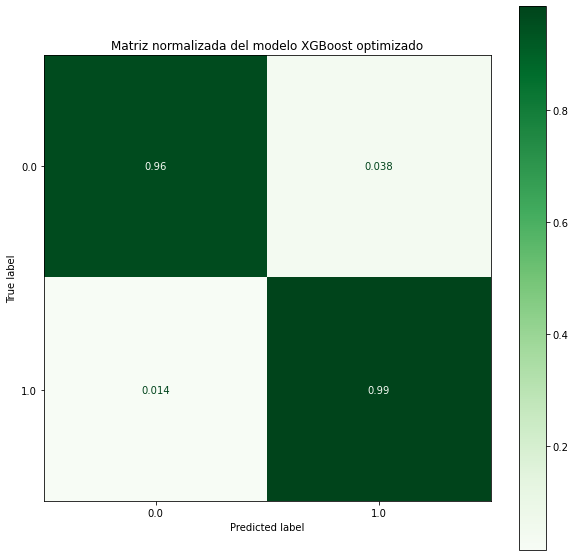

In [12]:
# Plotting optimized confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay.from_predictions(ytest, ypred,
                                                       cmap=plt.cm.Greens,
                                                       normalize='true',
                                                       ax=ax)
ax.set_title('Matriz normalizada del modelo XGBoost optimizado')

## Adjust the prediction

In [13]:
# keep probabilities for the positive outcome only
yhat = ypred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)
evaluate_model(ytest,ypred_new_threshold,ypred_proba)

Best Threshold=0.637080, G-Mean=0.976
ROC-AUC score of the model: 0.9967510475556527

F2 Score: 0.5523953033819944

R2 Score: -31.006800748333568

Accuracy of the model: 0.9651997884114584

Classification report: 
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98    196394
         1.0       0.03      0.98      0.06       214

    accuracy                           0.97    196608
   macro avg       0.51      0.97      0.52    196608
weighted avg       1.00      0.97      0.98    196608




### Conclusion

With the hyperparameters adjusted we can see that the recall, which is the parameter to evaluate, increase a little bit from 97% to 96%.